In [1]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install descartes

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import sklearn
import sklearn.datasets
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import sklearn.linear_model as lm
from sklearn.model_selection import KFold
from sklearn import ensemble
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

In [4]:
# from google.colab import files
# uploaded = files.upload()

# Merging and Cleaning Datasets

In [5]:
counties = pd.read_csv('abridged_couties.csv')
counties = counties.drop(columns =[x for x in list(counties.columns) if "PopMale" in x or "PopFmle" in x or "3-YrMortalityAge" in x])
counties = counties.drop(columns =['countyFIPS', 'STATEFP', 'COUNTYFP', 'StateName', 'FracMale2017', 'PopTotalMale2017', 'PopTotalFemale2017','mortality2015-17Estimated'])
#create Combined_key column which will be used later to join with other datasets
counties['Combined_Key'] = counties['CountyName'] + ', ' + counties['State'] + ', US'


In [6]:
deaths = pd.read_csv('time_series_covid19_deaths_US.csv')

deaths["Total Deaths"] = deaths['4/18/20'] - deaths['3/18/20']
deaths = deaths[['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State', 'Country_Region', 
                       'Lat', 'Long_', 'Combined_Key','Population','Total Deaths']]

In [7]:
confirmed = pd.read_csv('time_series_covid19_confirmed_US.csv')
confirmed_row_names = list(confirmed)

confirmed["Total Confirmed"] = confirmed['3/18/20']
confirmed = confirmed[['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State', 'Country_Region', 
                       'Lat', 'Long_', 'Combined_Key', 'Total Confirmed']]


In [8]:
confirmed = confirmed[['Combined_Key', 'Total Confirmed']]
confirmed
deaths = deaths [['Combined_Key', 'Population', 'Lat', 'Long_', 'Total Deaths']]
deaths
confirmed_deaths = confirmed.set_index('Combined_Key').join(deaths.set_index('Combined_Key'), how = 'inner').reset_index()
data = confirmed_deaths.set_index('Combined_Key').join(counties.set_index('Combined_Key'), how = 'inner')

In [9]:
#drop columns that have lots of NaN values since they would be useless anyways and since some other column with few NaN values
#had redundant data

data_col = data.isna().sum().sort_values(ascending=False)[:40]
data = data.dropna(axis=1).drop(['POP_LONGITUDE','POP_LATITUDE'], axis=1)
map_data_prev = data

In [10]:
def ranges(x):
    if x == 0:
        return 0
    if x > 0 and x <= 10:
        return 1
    if x > 10 and x <= 25:
        return 2
    if x > 25 and x <= 50:
        return 3
    if x > 50 and x <= 100:
        return 4
    if x > 100 and x <= 300:
        return 5 
    if x > 300 and x <= 500:
        return 6
    if x > 500 and x <= 700:
        return 7
    else:
        return 8
# map death numbers to bins
data['Deaths'] = data['Total Deaths'].apply(ranges)

### Combined Data

In [11]:
data

,Total Confirmed,Population,Lat,Long_,Total Deaths,CountyName,State,lat,lon,CensusRegionName,...,"TotalM.D.'s,TotNon-FedandFed2017",#HospParticipatinginNetwork2017,#Hospitals,#ICU_beds,dem_to_rep_ratio,public schools,restaurant dine-in,federal guidelines,foreign travel ban,Deaths
Combined_Key,,,,,,,,,,,,,,,,,,,,,
"Abbeville, South Carolina, US",0,24527,34.223334,-82.461707,0,Abbeville,South Carolina,34.230215,-82.458508,South,...,22.0,1.0,1.0,6.0,0.553157,737500.0,737502.0,737500.0,737495.0,0
"Acadia, Louisiana, US",0,62045,30.295065,-92.414197,7,Acadia,Louisiana,30.299092,-92.407160,South,...,51.0,0.0,2.0,4.0,0.266421,737500.0,737501.0,737500.0,737495.0,1
"Accomack, Virginia, US",0,32316,37.767072,-75.632346,0,Accomack,Virginia,37.952668,-75.308162,South,...,38.0,0.0,1.0,10.0,0.785273,737500.0,737507.0,737500.0,737495.0,0
"Ada, Idaho, US",3,481587,43.452658,-116.241552,9,Ada,Idaho,43.446639,-116.235129,West,...,1642.0,3.0,3.0,105.0,0.807204,737507.0,737507.0,737500.0,737495.0,1
"Adair, Iowa, US",1,7152,41.330756,-94.471059,0,Adair,Iowa,41.333176,-94.477875,Midwest,...,3.0,1.0,1.0,0.0,0.460382,737517.0,737501.0,737500.0,737495.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Yuma, Arizona, US",0,213787,32.768957,-113.906667,1,Yuma,Arizona,32.779782,-113.907858,West,...,331.0,0.0,1.0,42.0,0.977747,737500.0,737503.0,737500.0,737495.0,1
"Yuma, Colorado, US",0,10019,40.003468,-102.425867,0,Yuma,Colorado,40.006686,-102.424616,West,...,8.0,0.0,2.0,0.0,0.188571,737507.0,737504.0,737500.0,737495.0,0
"Zapata, Texas, US",0,14179,27.001564,-99.169872,0,Zapata,Texas,27.008292,-99.177587,South,...,3.0,0.0,0.0,0.0,2.004859,737507.0,737503.0,737500.0,737495.0,0


# Visualizations

Text(0.5, 0, 'Division Name')

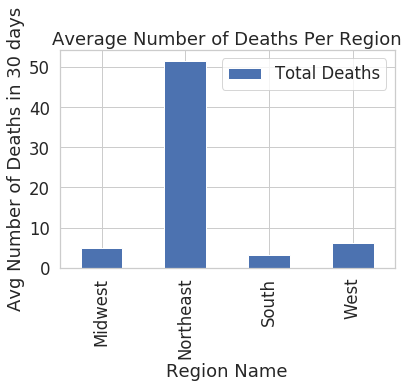

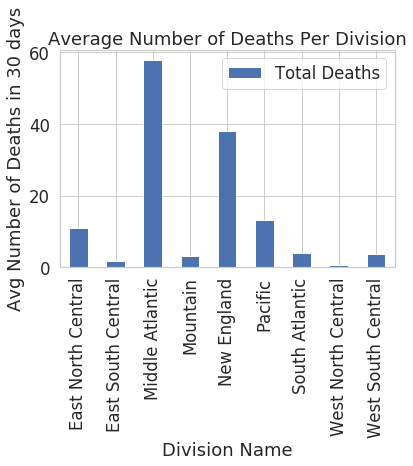

In [12]:
deaths_region = data[['CensusRegionName', 'Total Deaths' ]]
deaths_region = deaths_region.groupby(by = 'CensusRegionName').agg(np.average)
deaths_region
deaths_region.plot.bar()
plt.ylabel("Avg Number of Deaths in 30 days")
plt.title("Average Number of Deaths Per Region")
plt.xlabel("Region Name")

deaths_region = data[['CensusDivisionName', 'Total Deaths' ]]
deaths_region = deaths_region.groupby(by = 'CensusDivisionName').agg(np.average)
deaths_region
deaths_region.plot.bar()
plt.ylabel("Avg Number of Deaths in 30 days")
plt.title("Average Number of Deaths Per Division")
plt.xlabel("Division Name")

The graph shows the most average deaths were in the Northeast region with not too many big differences between other regions. The divisions however, had much more differences among their average rates.

Text(0, 0.5, 'Total Deaths in One Month')

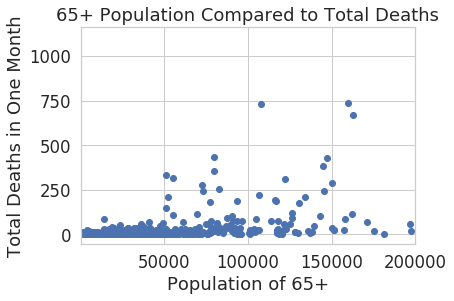

In [13]:
plt.scatter(data['PopulationEstimate65+2017'], data['Total Deaths'])
plt.xlim(1,200000)
plt.title("65+ Population Compared to Total Deaths")
plt.xlabel("Population of 65+")
plt.ylabel("Total Deaths in One Month")

Since this population is at-most risk for the virus, we thought that there would be a relatively strong correlation between population numbers and total deaths, but most of the data points are congregated around 0 with no obvious strong visible correlation

Text(0.5, 0, 'Region Name')

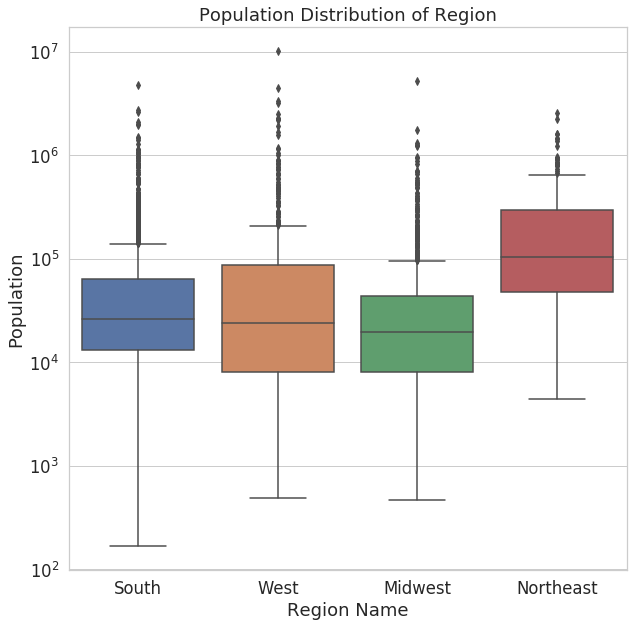

In [14]:
northeast = data[data['CensusRegionName'] == 'Northeast']
northeast
plt.figure(figsize=(10, 10))
plot = sns.boxplot(x = 'CensusRegionName', y = 'Population', data = data)
plot.set_yscale('log')
plt.title("Population Distribution of Region")
plt.xlabel("Region Name")

This shows the distribution of population numbers by region. The boxplots tend to be small, except for in the West.

Text(0, 0.5, 'Population Density per Square Mile')

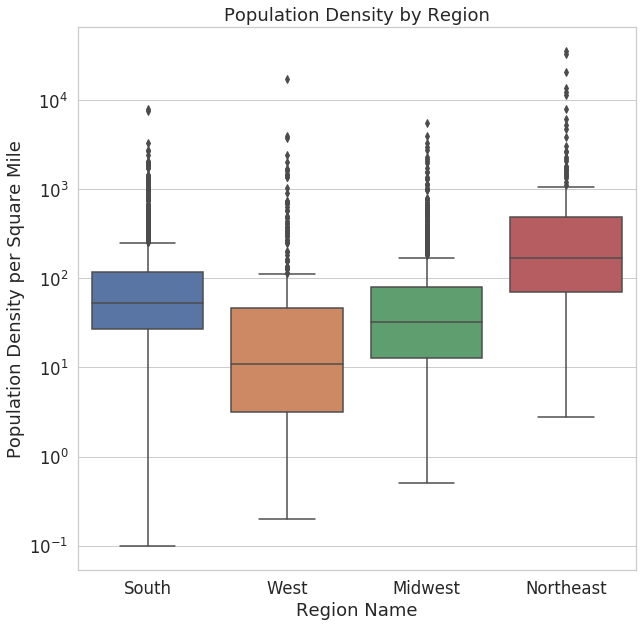

In [15]:
plt.figure(figsize=(10, 10))
#sns.boxplot(northeast['Population']/10000)
plot = sns.boxplot(x = 'CensusRegionName', y = 'PopulationDensityperSqMile2010', data = data)
plot.set_yscale('log')
plt.title("Population Density by Region")
plt.xlabel("Region Name")
plt.ylabel("Population Density per Square Mile")

This shows similar trends as the plot above showing simply population except that the South has a higher density than the West, which wasn't true for it's population numbers

Text(0.5, 0, 'Rural-Urban Continuum Code')

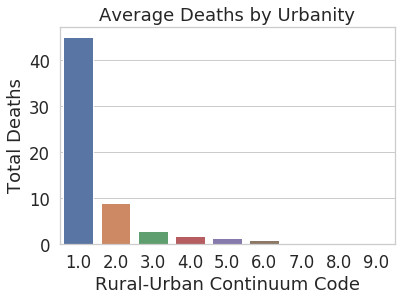

In [16]:
sns.barplot(x = 'Rural-UrbanContinuumCode2013', y = 'Total Deaths', data = data, ci = None )
plt.title("Average Deaths by Urbanity")
plt.xlabel("Rural-Urban Continuum Code")

The rural-urban continuum code shows that as the number gets smaller, the more urban and metropolitan-like the counties get. There was an increasingly bigger drop in average deaths.

(0, 10)

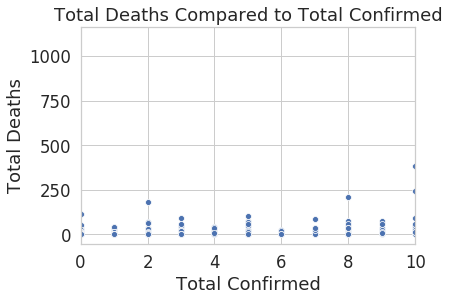

In [17]:
data['Population in 100000s'] = data['Population']/100000
temp = data[data['Total Confirmed'] <= 1000]
temp = temp[temp['Total Deaths'] <= 5000]
sns.scatterplot(x="Total Confirmed", y="Total Deaths", data=temp)
plt.title("Total Deaths Compared to Total Confirmed")
plt.xlim(0,10)

Most of the data points are cornered near 0, and some show the trend of having more deaths for more confirmed cases

In [18]:
fp = "tl_2017_us_county.shp"

map_df = gpd.read_file(fp)
map_data_prev = map_data_prev.rename(columns = {"Total Deaths": "TotalDeaths"})
df = map_data_prev
#df = df.rename(columns = {'CountyName': 'NAME'})
df = df.reset_index()
df = df.rename(columns = {'CountyName': 'NAME'})
df = df[['NAME', 'TotalDeaths','RespMortalityRate2014', 'Deaths']]
df.head()

,NAME,TotalDeaths,RespMortalityRate2014,Deaths
0,Abbeville,0,59.27,0
1,Acadia,7,56.09,1
2,Accomack,0,60.31,0
3,Ada,9,54.67,1
4,Adair,0,47.06,0


In [19]:
map_df.head()

,FID,geometry
0,0,"POLYGON ((-97.01936 42.09058, -97.01874 42.090..."
1,1,"POLYGON ((-123.72832 46.26454, -123.72755 46.2..."
2,2,"POLYGON ((-104.89338 34.08841, -104.89334 34.0..."
3,3,"POLYGON ((-96.91094 41.04612, -96.90851 41.046..."
4,4,"POLYGON ((-98.27357 40.35036, -98.27355 40.350..."


In [20]:
#merged = map_df.set_index('NAME').join(df.set_index('NAME'))
merged = map_df.join(df.set_index('NAME'))
merged

,FID,geometry,TotalDeaths,RespMortalityRate2014,Deaths
0,0,"POLYGON ((-97.01936 42.09058, -97.01874 42.090...",NaN,NaN,NaN
1,1,"POLYGON ((-123.72832 46.26454, -123.72755 46.2...",NaN,NaN,NaN
2,2,"POLYGON ((-104.89338 34.08841, -104.89334 34.0...",NaN,NaN,NaN
3,3,"POLYGON ((-96.91094 41.04612, -96.90851 41.046...",NaN,NaN,NaN
4,4,"POLYGON ((-98.27357 40.35036, -98.27355 40.350...",NaN,NaN,NaN
...,...,...,...,...,...
3228,3228,"POLYGON ((-84.61864 34.85540, -84.61754 34.855...",NaN,NaN,NaN
3229,3229,"POLYGON ((-96.40541 48.99998, -96.39608 48.999...",NaN,NaN,NaN
3230,3230,"POLYGON ((-89.96588 32.87957, -89.96584 32.879...",NaN,NaN,NaN
3231,3231,"POLYGON ((-101.68874 32.52522, -101.68677 32.5...",NaN,NaN,NaN


This map shows the range of deaths per county available in the dataset across the US.

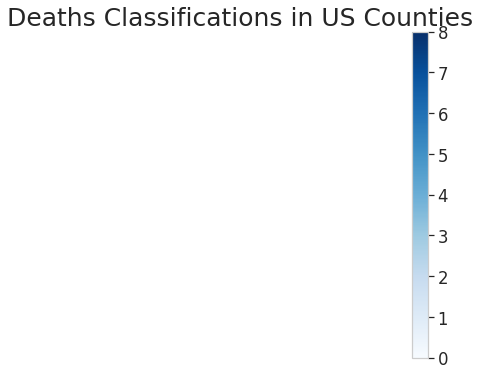

In [21]:
variable = 'Deaths'

# set the range for the choropleth
vmin, vmax = 0, 8

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))

# create map
merged.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')

# Now we can customise and add annotations

# remove the axis
ax.axis('off')

# add a title
ax.set_title('Deaths Classifications in US Counties', \
              fontdict={'fontsize': '25',
                        'fontweight' : '3'})

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)

# this will save the figure as a high-res png. you can also save as svg
fig.savefig('testmap.png', dpi=300)

In [22]:
# from google.colab import files
# uploaded = files.upload()

In [23]:
fp = "cb_2019_06_cousub_500k.shp"

map_df = gpd.read_file(fp)
map_data_prev = map_data_prev.rename(columns = {"Total Deaths": "TotalDeaths"})
df = map_data_prev
df = df.reset_index()
df = df.rename(columns = {'CountyName': 'NAME'})
df = df[['NAME', 'TotalDeaths','RespMortalityRate2014', 'Deaths']]

merged = map_df.set_index('NAME').join(df.set_index('NAME'))
# merged

This map shows the range of deaths per county available in the dataset in California.

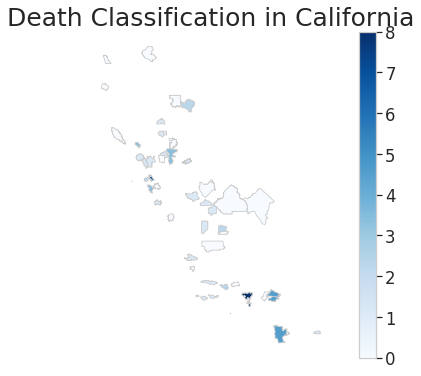

In [24]:
variable = 'Deaths'

# set the range for the choropleth
vmin, vmax = 0, 8

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))

# create map
merged.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')

# Now we can customise and add annotations

# remove the axis
ax.axis('off')

# add a title
ax.set_title('Death Classification in California', \
              fontdict={'fontsize': '25',
                        'fontweight' : '3'})

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)

# this will save the figure as a high-res png. you can also save as svg
fig.savefig('testmap.png', dpi=300)

In [25]:
# from google.colab import files
# uploaded = files.upload()

In [26]:
fp = "cb_2019_36_cousub_500k.shp"

map_df = gpd.read_file(fp)
map_data_prev = map_data_prev.rename(columns = {"Total Deaths": "TotalDeaths"})
df = map_data_prev
#df = df.rename(columns = {'CountyName': 'NAME'})
df = df.reset_index()
df = df.rename(columns = {'CountyName': 'NAME'})
df = df[['NAME',  'TotalDeaths','RespMortalityRate2014', 'Deaths']]

merged = map_df.set_index('NAME').join(df.set_index('NAME'))
# merged

This map shows the range of deaths per county available in the dataset in New York.

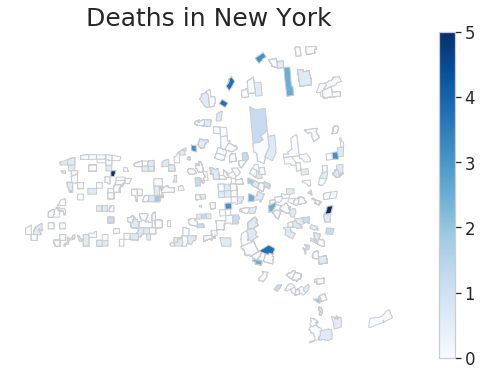

In [27]:
variable = 'Deaths'

# set the range for the choropleth
vmin, vmax = 0, 5

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))

# create map
merged.plot(column=variable, cmap='Blues', linewidth=1, ax=ax, edgecolor='0.8')

# Now we can customise and add annotations

# remove the axis
ax.axis('off')

# add a title
ax.set_title('Deaths in New York', \
              fontdict={'fontsize': '25',
                        'fontweight' : '3'})

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)

# this will save the figure as a high-res png. you can also save as svg
fig.savefig('testmap.png', dpi=300)

# Final Data Cleaning after Creating Visualizations

In [28]:
data = data.reset_index(drop=True) #drop names of states/counties

In [29]:
#one hot encode the region names
oh_enc = pd.get_dummies(data[['CensusDivisionName','CensusRegionName']]) 
data = pd.concat([oh_enc,data],axis=1).drop(columns=['CensusDivisionName','CensusRegionName'])

In [30]:
model_data = data.drop(["CensusPopulation2010",'PopulationEstimate2018','#EligibleforMedicare2018','MedianAge2010','State','Lat','Long_'], axis=1)

# Feature Selection and Creating a Model

In [31]:
# Normalize model_data and split in train and test set
from sklearn import preprocessing

X = model_data.drop(['Deaths', 'Total Deaths', 'CountyName'],axis=1)
Y = pd.Series(model_data['Deaths'])
X_normalized = X - np.mean(X, axis=0)
X_train, X_test, Y_train, Y_test = train_test_split(X_normalized, Y, test_size=0.1)


In [32]:
from sklearn.model_selection import cross_val_score

# wanted to get an idea of which features can increase/decrease the total accuracy to get a rough idea of which features mattered
# (we knew this wasn't the most accurate way to find results so we )
X_tr = X_train
range_of_num_features = range(1, X_train.shape[1] + 1)
scores = []
for N in range_of_num_features:
    print(f"Trying first {N} features")
    model = ensemble.RandomForestClassifier(random_state=42)
    
    # compute the cross validation error
    score = np.mean(cross_val_score(model, X_tr.iloc[:, :N], Y_train, cv=5))
    
    print("\tscore:", score)
    scores.append(score)

#pick number of features with best score
best_num_features = np.argmax(scores, axis=0) + 1
best_err = scores[best_num_features - 1] 
print(f"Best choice, use the first {best_num_features} features with {best_err} accuracy score in validation set")

Trying first 1 features


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


	score: 0.6257378374888721
Trying first 2 features


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


	score: 0.6257378374888721
Trying first 3 features


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


	score: 0.6279545778883203
Trying first 4 features


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


	score: 0.6279545778883203
Trying first 5 features


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


	score: 0.6279545778883203
Trying first 6 features


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


	score: 0.6279545778883203
Trying first 7 features


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


	score: 0.6279545778883203
Trying first 8 features


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


	score: 0.6279545778883203
Trying first 9 features


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


	score: 0.6279545778883203
Trying first 10 features


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


	score: 0.6279545778883203
Trying first 11 features


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


	score: 0.6279545778883203
Trying first 12 features


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


	score: 0.6279545778883203
Trying first 13 features


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


	score: 0.6279545778883203
Trying first 14 features


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


	score: 0.6648216482164823
Trying first 15 features


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


	score: 0.6334746828131264
Trying first 16 features


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


	score: 0.6840016853207207
Trying first 17 features


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


	score: 0.7098061201606491
Trying first 18 features


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


	score: 0.7035418917725089
Trying first 19 features


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


	score: 0.7146011294367088
Trying first 20 features


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


	score: 0.7120181036064505
Trying first 21 features


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


	score: 0.7153418550760093
Trying first 22 features


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


	score: 0.724550637771571
Trying first 23 features


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


	score: 0.7193920613239282
Trying first 24 features


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


	score: 0.7190291737171515
Trying first 25 features


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


	score: 0.7193961387127683
Trying first 26 features


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


	score: 0.7219757667189932
Trying first 27 features


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


	score: 0.7145997703070954
Trying first 28 features


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


	score: 0.7260307299205591
Trying first 29 features


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


	score: 0.7201368643520689
Trying first 30 features


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


	score: 0.7197665015324187
Trying first 31 features


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


	score: 0.7216169565010567
Trying first 32 features


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


	score: 0.7208775899913695
Trying first 33 features


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


	score: 0.7164502252757334
Trying first 34 features


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


	score: 0.7216094812881831
Trying first 35 features


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


	score: 0.7230882143075574
Best choice, use the first 28 features with 0.7260307299205591 accuracy score in validation set


In [33]:
list(X_tr.columns) # to see the names of features being selected

['CensusDivisionName_East North Central',
 'CensusDivisionName_East South Central',
 'CensusDivisionName_Middle Atlantic',
 'CensusDivisionName_Mountain',
 'CensusDivisionName_New England',
 'CensusDivisionName_Pacific',
 'CensusDivisionName_South Atlantic',
 'CensusDivisionName_West North Central',
 'CensusDivisionName_West South Central',
 'CensusRegionName_Midwest',
 'CensusRegionName_Northeast',
 'CensusRegionName_South',
 'CensusRegionName_West',
 'Total Confirmed',
 'Population',
 'lat',
 'lon',
 'Rural-UrbanContinuumCode2013',
 'PopulationEstimate65+2017',
 'PopulationDensityperSqMile2010',
 'DiabetesPercentage',
 'HeartDiseaseMortality',
 'Smokers_Percentage',
 'RespMortalityRate2014',
 '#FTEHospitalTotal2017',
 "TotalM.D.'s,TotNon-FedandFed2017",
 '#HospParticipatinginNetwork2017',
 '#Hospitals',
 '#ICU_beds',
 'dem_to_rep_ratio',
 'public schools',
 'restaurant dine-in',
 'federal guidelines',
 'foreign travel ban',
 'Population in 100000s']

In [34]:
# using feature selection to find variables to use in training set
from sklearn import feature_selection
u, s, vt = np.linalg.svd(X_train, full_matrices=False)
s**2 / sum(s**2)
# found out that most data doesn't have a lot of variance and won't affect prediction as much since most variance of data
# comes from jus a few columns 

array([9.99319721e-01, 6.04313281e-04, 6.52787862e-05, 9.88159291e-06,
       7.79625766e-07, 1.72479724e-08, 3.77111125e-09, 1.50052102e-09,
       1.32855649e-09, 9.96813218e-10, 1.75257586e-10, 1.36328620e-10,
       1.02014335e-10, 7.65050577e-11, 4.82912821e-11, 3.86762274e-11,
       6.91638823e-12, 3.81823910e-12, 2.74690156e-12, 2.11628911e-12,
       1.12637098e-12, 1.06099074e-12, 1.01754611e-12, 8.78892630e-13,
       4.33842237e-13, 2.34433641e-13, 6.88671190e-14, 4.60189382e-32,
       5.29576616e-33, 5.29576616e-33, 5.29576616e-33, 5.29576616e-33,
       5.29576616e-33, 5.29576616e-33, 5.29576616e-33])

In [35]:
# Fitting a Random Forest Classification model and finding the accuracy score on test set
model = ensemble.RandomForestClassifier(random_state=42)
X_tr = X_train
model.fit(X_tr,Y_train)
print("Cross Validaton score w all features: " + str(np.mean(cross_val_score(model, X_tr, Y_train, cv=5))))
print("Test set score w all features: " + str(accuracy_score(model.predict(X_test),Y_test)))

/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Cross Validaton score w all features: 0.7230882143075574
Test set score w all features: 0.7218543046357616


In [36]:

model = ensemble.RandomForestClassifier(random_state=42)
feat_labels = list(X_train.columns) 
# this threshold number below was played around with many times to find the features that were least redundant and 
# had helped determine the classification the most
sfm = SelectFromModel(model, threshold='mean')
sfm.fit(X_train, Y_train)
print("Features included:")
for feature_list_index in sfm.get_support(indices=True):
    print(feat_labels[feature_list_index])
X_important_train = sfm.transform(X_train)
clf_important = ensemble.RandomForestClassifier(random_state=43)
clf_important.fit(X_important_train, Y_train)
print("CV score w features above threshold: "+ str(np.mean(cross_val_score(clf_important, X_important_train, Y_train, cv=5))))
print("Test score w features above threshold: "+ str(accuracy_score(clf_important.predict(sfm.transform(X_test)),Y_test)))

Features included:
Population
lat
lon
Rural-UrbanContinuumCode2013
PopulationEstimate65+2017
PopulationDensityperSqMile2010
DiabetesPercentage
HeartDiseaseMortality
Smokers_Percentage
RespMortalityRate2014
#FTEHospitalTotal2017
TotalM.D.'s,TotNon-FedandFed2017
#ICU_beds
dem_to_rep_ratio
Population in 100000s


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


CV score w features above threshold: 0.7205031497828791
Test score w features above threshold: 0.7019867549668874


In [37]:
# Training Random Forest Classification model on features selected to get final test accuracy score 
model = ensemble.RandomForestClassifier(random_state=42)
X_tr = X_train[['Population','lon','lat']]
model.fit(X_tr,Y_train)
print("Cross Validaton score w 3 features: " + str(np.mean(cross_val_score(model, X_tr, Y_train, cv=5))))
print("Test set score w 3 features: " + str(accuracy_score(model.predict(X_test[['Population','lon','lat']]),Y_test)))

/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Cross Validaton score w 3 features: 0.7149701331267456
Test set score w 3 features: 0.7284768211920529
